# Stock Market Analysis

### This notebook uses LSTM models to predict whether stock prices go up or down.
### For this, Technical Indicators are calculated on stock data.

In [1]:
# Import Modules

import numpy as np
import pandas as pd
import os
import random
import copy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

## Read the data from Stock folder

### Check how much data is available? 

In [13]:
list = os.listdir("./Stocks/")
number_files = len(list)
print(number_files)

7196


### Choose 15 random stock data for analysis

In [14]:
#filenames = [x for x in os.listdir("./Stocks/") if x.endswith('.txt') and os.path.getsize(x) > 0]
filenames = random.sample([x for x in os.listdir("./Stocks/") if x.endswith('.txt') 
                           and os.path.getsize(os.path.join("./Stocks",x)) > 0], 15)
print(filenames)

['lea.us.txt', 'ffbcw.us.txt', 'usa.us.txt', 'pfh.us.txt', 'ne.us.txt', 'neos.us.txt', 'visi.us.txt', 'lulu.us.txt', 'fnd.us.txt', 'ctmx.us.txt', 'mcef.us.txt', 'star_d.us.txt', 'cci.us.txt', 'ddbi.us.txt', 'tcrd.us.txt']


### Read data into dataframes

In [16]:
df = []
for filename in filenames:
    dff = pd.read_csv(os.path.join("./Stocks",filename), sep=',')
    label, _, _ = filename.split(sep='.')
    dff['Label'] = label
    dff['Date'] = pd.to_datetime(dff['Date'])
    df.append(dff)

In [17]:
df[0].head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label
0,2009-11-09,23.465,27.626,23.465,26.135,2696611,0,lea
1,2009-11-10,26.135,26.484,25.667,26.461,3334400,0,lea
2,2009-11-11,26.715,28.163,26.461,27.995,1662457,0,lea
3,2009-11-12,29.737,30.204,29.207,29.599,4300770,0,lea
4,2009-11-13,29.737,30.668,29.737,30.204,3287720,0,lea


In [19]:
# We will consider the data with maximum entries among those 15 random datasets
len_of_data = []
for i in range(len(df)):
    len_of_data.append(len(df[i]))
print(max(len_of_data))

index = len_of_data.index(max(len_of_data))
print(index)

6962
4


## Add various Technical Indicators in the dataframe

There are four types of Technical Indicators. Lets us take 4 sets of indicators and test which performs better in prediction of stock markets.
These 4 sets of Technical Indicators are:
- RSI, Volume (plain), Bollinger Bands, Aroon, Price Volume Trend, acceleration bands
- Stochastic, Chaikin Money Flow, Parabolic SAR, Rate of Change, Volume weighted average Price, momentum
- Commodity Channel Index, On Balance Volume, Keltner Channels, Triple Exponential Moving Average, Normalized Averager True Range ,directional movement indicators
- MACD, Money flowindex , Ichimoku, William %R, Volume MINMAX, adaptive moving average

In [20]:

# Create 4 copies of data to add columns of different sets of Technical Indicators
data = df[index]
techindi1 = copy.deepcopy(data)
techindi2 = copy.deepcopy(data)
techindi3 = copy.deepcopy(data)
techindi4 = copy.deepcopy(data)

# techindi1 dataframe

### Calculation of Relative Strength Index (RSI)

In [21]:
# Relative Strength Index
# Avg(PriceUp)/(Avg(PriceUP)+Avg(PriceDown)*100
# Where: PriceUp(t)=1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)>0};
#        PriceDown(t)=-1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)<0};

def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)


In [24]:
# Add Momentum_1D column for all 15 stocks.
# Momentum_1D = P(t) - P(t-1)

techindi1['Momentum_1D'] = (techindi1['Close']-techindi1['Close'].shift(1)).fillna(0)
techindi1['RSI_14D'] = techindi1['Momentum_1D'].rolling(center=False, window=14).apply(rsi).fillna(0)
techindi1.tail(5)

,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,0.26,62.711864
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,-0.03,65.486726
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,0.14,64.705882
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,0.17,74.468085
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,0.00,74.468085


### Calculation of Volume (Plain)

In [25]:

techindi1['Volume_plain'] = techindi1['Volume'].fillna(0)
techindi1.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D,Volume_plain
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,0.26,62.711864,10497465
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,-0.03,65.486726,5663255
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,0.14,64.705882,10117386
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,0.17,74.468085,8542093
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,0.00,74.468085,8632115


### Calculation of Bollinger Bands

In [26]:
def bbands(price, length=30, numsd=2):
    """ returns average, upper band, and lower band"""
    ave = pd.stats.moments.rolling_mean(price,length)
    sd = pd.stats.moments.rolling_std(price,length)
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [27]:
techindi1['BB_Middle_Band'], techindi1['BB_Upper_Band'], techindi1['BB_Lower_Band'] = bbands(techindi1['Close'], length=20, numsd=1)
techindi1['BB_Middle_Band'] = techindi1['BB_Middle_Band'].fillna(0)
techindi1['BB_Upper_Band'] = techindi1['BB_Upper_Band'].fillna(0)
techindi1['BB_Lower_Band'] = techindi1['BB_Lower_Band'].fillna(0)
techindi1.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  after removing the cwd from sys.path.


,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,0.26,62.711864,10497465,3.991,4.142,3.841
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,-0.03,65.486726,5663255,4.013,4.178,3.848
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,0.14,64.705882,10117386,4.044,4.231,3.858
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,0.17,74.468085,8542093,4.085,4.305,3.866
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,0.00,74.468085,8632115,4.119,4.368,3.870


### Calculation of Aroon Oscillator

In [28]:
def aroon(df, tf=25):
    aroonup = []
    aroondown = []
    x = tf
    while x< len(df['Date']):
        aroon_up = ((df['High'][x-tf:x].tolist().index(max(df['High'][x-tf:x])))/float(tf))*100
        aroon_down = ((df['Low'][x-tf:x].tolist().index(min(df['Low'][x-tf:x])))/float(tf))*100
        aroonup.append(aroon_up)
        aroondown.append(aroon_down)
        x+=1
    return aroonup, aroondown

In [29]:
listofzeros = [0] * 25
up, down = aroon(techindi1)
aroon_list = [x - y for x, y in zip(up,down)]
if len(aroon_list)==0:
    aroon_list = [0] * techindi1.shape[0]
    techindi1['Aroon_Oscillator'] = aroon_list
else:
    techindi1['Aroon_Oscillator'] = listofzeros+aroon_list


### Calculation of Price Volume Trend

PVT = [((CurrentClose - PreviousClose) / PreviousClose) x Volume] + PreviousPVT

In [30]:
techindi1["PVT"] = (techindi1['Momentum_1D']/ techindi1['Close'].shift(1))*techindi1['Volume']
techindi1["PVT"] = techindi1["PVT"]-techindi1["PVT"].shift(1)
techindi1["PVT"] = techindi1["PVT"].fillna(0)
techindi1.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,0.26,62.711864,10497465,3.991,4.142,3.841,-32.0,702940.683764
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,-0.03,65.486726,5663255,4.013,4.178,3.848,-24.0,-706377.444482
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,0.14,64.705882,10117386,4.044,4.231,3.858,-24.0,366935.181034
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,0.17,74.468085,8542093,4.085,4.305,3.866,76.0,-2282.776906
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,0.00,74.468085,8632115,4.119,4.368,3.870,80.0,-325595.473094


### Calculation of Acceleration Bands

In [31]:
def abands(df):
    df['AB_Middle_Band'] = pd.rolling_mean(df['Close'], 20)
    # High * ( 1 + 4 * (High - Low) / (High + Low))
    df['aupband'] = df['High'] * (1 + 4 * (df['High']-df['Low'])/(df['High']+df['Low']))
    df['AB_Upper_Band'] = pd.rolling_mean(df['aupband'], 20)
    # Low *(1 - 4 * (High - Low)/ (High + Low))
    df['adownband'] = df['Low'] * (1 - 4 * (df['High']-df['Low'])/(df['High']+df['Low']))
    df['AB_Lower_Band'] = pd.rolling_mean(df['adownband'], 20)

In [32]:
abands(techindi1)
techindi1 = techindi1.fillna(0)
techindi1.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  """
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  


,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D,...,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT,AB_Middle_Band,aupband,AB_Upper_Band,adownband,AB_Lower_Band
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,0.26,62.711864,...,3.991,4.142,3.841,-32.0,702940.683764,3.9915,5.062532,4.486062,3.512532,3.515737
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,-0.03,65.486726,...,4.013,4.178,3.848,-24.0,-706377.444482,4.0130,4.710565,4.485113,3.935565,3.546038
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,0.14,64.705882,...,4.044,4.231,3.858,-24.0,366935.181034,4.0445,5.086587,4.525093,3.736587,3.560168
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,0.17,74.468085,...,4.085,4.305,3.866,76.0,-2282.776906,4.0855,5.078753,4.571190,4.078753,3.596265
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,0.00,74.468085,...,4.119,4.368,3.870,80.0,-325595.473094,4.1190,5.325110,4.611334,4.000110,3.625159


## Drop unwanted columns

In [33]:
columns2Drop = ['Momentum_1D', 'aupband', 'adownband']
techindi1 = techindi1.drop(labels = columns2Drop, axis=1)
techindi1.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT,AB_Middle_Band,AB_Upper_Band,AB_Lower_Band
0,1990-03-26,3.0453,3.0946,3.0030,3.0030,36801,0,ne,0.0,36801,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,1990-03-27,3.0030,3.0946,3.0030,3.0030,18683,0,ne,0.0,18683,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,1990-03-28,3.0946,3.0946,3.0030,3.0453,39912,0,ne,0.0,39912,0.0,0.0,0.0,0.0,562.197003,0.0,0.0,0.0
3,1990-03-29,3.0946,3.0946,3.0453,3.0946,27458,0,ne,0.0,27458,0.0,0.0,0.0,0.0,-117.682702,0.0,0.0,0.0
4,1990-03-30,3.0030,3.0946,3.0030,3.0453,217108,0,ne,0.0,217108,0.0,0.0,0.0,0.0,-3903.256755,0.0,0.0,0.0


# techindi2 dataframe

### Calculation of Stochastic Oscillator (%K and %D)

In [34]:
def STOK(df, n):
    df['STOK'] = ((df['Close'] - pd.rolling_mean(df['Low'], n)) / (pd.rolling_max(df['High'], n) - pd.rolling_min(df['Low'],n))) * 100
    df['STOD'] = pd.rolling_mean(df['STOK'], 3)

In [35]:
STOK(techindi2, 4)
techindi2 = techindi2.fillna(0)
techindi2.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).max()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).min()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,56.018519,27.064293
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,45.370370,37.634016
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,51.923077,51.103989
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,64.285714,53.859721
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,47.916667,54.708486


### Calculation of Chaikin Money Flow

In [36]:
def CMFlow(df, tf):
    CHMF = []
    MFMs = []
    MFVs = []
    x = tf
    
    while x < len(df['Date']):
        PeriodVolume = 0
        volRange = df['Volume'][x-tf:x]
        for eachVol in volRange:
            PeriodVolume += eachVol
        
        MFM = ((df['Close'][x] - df['Low'][x]) - (df['High'][x] - df['Close'][x])) / (df['High'][x] - df['Low'][x])
        MFV = MFM*PeriodVolume
        
        MFMs.append(MFM)
        MFVs.append(MFV)
        x+=1
    
    y = tf
    while y < len(MFVs):
        PeriodVolume = 0
        volRange = df['Volume'][x-tf:x]
        for eachVol in volRange:
            PeriodVolume += eachVol
        consider = MFVs[y-tf:y]
        tfsMFV = 0
        
        for eachMFV in consider:
            tfsMFV += eachMFV
        
        tfsCMF = tfsMFV/PeriodVolume
        CHMF.append(tfsCMF)
        y+=1
    return CHMF

In [37]:
listofzeros = [0] * 40
CHMF = CMFlow(techindi2, 20)
if len(CHMF)==0:
    CHMF = [0] * techindi2.shape[0]
    techindi2['Chaikin_MF'] = CHMF
else:
    techindi2['Chaikin_MF'] = listofzeros+CHMF
techindi2.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,56.018519,27.064293,-2.310102
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,45.370370,37.634016,-1.082657
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,51.923077,51.103989,0.060924
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,64.285714,53.859721,1.052806
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,47.916667,54.708486,0.658461


### Calculation of Parabolic SAR

In [38]:
def psar(df, iaf = 0.02, maxaf = 0.2):
    length = len(df)
    dates = (df['Date'])
    high = (df['High'])
    low = (df['Low'])
    close = (df['Close'])
    psar = df['Close'][0:len(df['Close'])]
    psarbull = [None] * length
    psarbear = [None] * length
    bull = True
    af = iaf
    ep = df['Low'][0]
    hp = df['High'][0]
    lp = df['Low'][0]
    for i in range(2,length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
        reverse = False
        if bull:
            if df['Low'][i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = df['Low'][i]
                af = iaf
        else:
            if df['High'][i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = df['High'][i]
                af = iaf
        if not reverse:
            if bull:
                if df['High'][i] > hp:
                    hp = df['High'][i]
                    af = min(af + iaf, maxaf)
                if df['Low'][i - 1] < psar[i]:
                    psar[i] = df['Low'][i - 1]
                if df['Low'][i - 2] < psar[i]:
                    psar[i] = df['Low'][i - 2]
            else:
                if df['Low'][i] < lp:
                    lp = df['Low'][i]
                    af = min(af + iaf, maxaf)
                if df['High'][i - 1] > psar[i]:
                    psar[i] = df['High'][i - 1]
                if df['High'][i - 2] > psar[i]:
                    psar[i] = df['High'][i - 2]
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
    #return {"dates":dates, "high":high, "low":low, "close":close, "psar":psar, "psarbear":psarbear, "psarbull":psarbull}
    #return psar, psarbear, psarbull
    df['psar'] = psar
    #df['psarbear'] = psarbear
    #df['psarbull'] = psarbull

In [39]:
psar(techindi2)

techindi2.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF,psar
6957,2017-11-06,4.11,4.420,4.110,3.875874,10497465,0,ne,56.018519,27.064293,-2.310102,3.875874
6958,2017-11-07,4.38,4.395,4.240,3.880000,5663255,0,ne,45.370370,37.634016,-1.082657,3.880000
6959,2017-11-08,4.28,4.530,4.260,3.923200,10117386,0,ne,51.923077,51.103989,0.060924,3.923200
6960,2017-11-09,4.48,4.670,4.470,3.983880,8542093,0,ne,64.285714,53.859721,1.052806,3.983880
6961,2017-11-10,4.63,4.780,4.515,4.066214,8632115,0,ne,47.916667,54.708486,0.658461,4.066214


### Calculation of Price Rate of Change

In [40]:
# ROC = [(Close - Close n periods ago) / (Close n periods ago)] * 100

techindi2['ROC'] = ((techindi2['Close'] - techindi2['Close'].shift(12))/(techindi2['Close'].shift(12)))*100
techindi2 = techindi2.fillna(0)
techindi2.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF,psar,ROC
6957,2017-11-06,4.11,4.420,4.110,3.875874,10497465,0,ne,56.018519,27.064293,-2.310102,3.875874,5.042923
6958,2017-11-07,4.38,4.395,4.240,3.880000,5663255,0,ne,45.370370,37.634016,-1.082657,3.880000,4.881759
6959,2017-11-08,4.28,4.530,4.260,3.923200,10117386,0,ne,51.923077,51.103989,0.060924,3.923200,5.780391
6960,2017-11-09,4.48,4.670,4.470,3.983880,8542093,0,ne,64.285714,53.859721,1.052806,3.983880,7.150015
6961,2017-11-10,4.63,4.780,4.515,4.066214,8632115,0,ne,47.916667,54.708486,0.658461,4.066214,9.306839


### Calculation of Volume Weighted Average Price

In [42]:
techindi2['VWAP'] = np.cumsum(techindi2['Volume'] * (techindi2['High'] + techindi2['Low'])/2) / np.cumsum(techindi2['Volume'])
techindi2 = techindi2.fillna(0)
techindi2.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF,psar,ROC,VWAP
6957,2017-11-06,4.11,4.420,4.110,3.875874,10497465,0,ne,56.018519,27.064293,-2.310102,3.875874,5.042923,17.618260
6958,2017-11-07,4.38,4.395,4.240,3.880000,5663255,0,ne,45.370370,37.634016,-1.082657,3.880000,4.881759,17.616100
6959,2017-11-08,4.28,4.530,4.260,3.923200,10117386,0,ne,51.923077,51.103989,0.060924,3.923200,5.780391,17.612264
6960,2017-11-09,4.48,4.670,4.470,3.983880,8542093,0,ne,64.285714,53.859721,1.052806,3.983880,7.150015,17.609071
6961,2017-11-10,4.63,4.780,4.515,4.066214,8632115,0,ne,47.916667,54.708486,0.658461,4.066214,9.306839,17.605865


### Calculation of Momentum 

In [43]:
techindi2['Momentum'] = techindi2['Close'] - techindi2['Close'].shift(4)
techindi2 = techindi2.fillna(0)
techindi2.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF,psar,ROC,VWAP,Momentum
6957,2017-11-06,4.11,4.420,4.110,3.875874,10497465,0,ne,56.018519,27.064293,-2.310102,3.875874,5.042923,17.618260,0.111269
6958,2017-11-07,4.38,4.395,4.240,3.880000,5663255,0,ne,45.370370,37.634016,-1.082657,3.880000,4.881759,17.616100,0.097979
6959,2017-11-08,4.28,4.530,4.260,3.923200,10117386,0,ne,51.923077,51.103989,0.060924,3.923200,5.780391,17.612264,0.107940
6960,2017-11-09,4.48,4.670,4.470,3.983880,8542093,0,ne,64.285714,53.859721,1.052806,3.983880,7.150015,17.609071,0.137376
6961,2017-11-10,4.63,4.780,4.515,4.066214,8632115,0,ne,47.916667,54.708486,0.658461,4.066214,9.306839,17.605865,0.190341


# techindi3 dataframe

### Calculation of Commodity Channel Index

In [44]:
def CCI(df, n, constant):
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    CCI = pd.Series((TP - pd.rolling_mean(TP, n)) / (constant * pd.rolling_std(TP,n))) #, name = 'CCI_' + str(n))
    return CCI

In [45]:
techindi3['CCI'] = CCI(techindi3, 20, 0.015)
techindi3 = techindi3.fillna(0)
techindi3.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,141.466756
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,129.142119
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,141.090915
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,165.015640
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,147.157242


### Calculation of On Balance Volume

            
If the closing price is above the prior close price then: 
Current OBV = Previous OBV + Current Volume

If the closing price is below the prior close price then: 
Current OBV = Previous OBV  -  Current Volume

If the closing prices equals the prior close price then:
Current OBV = Previous OBV (no change)

In [46]:
new = (techindi3['Volume'] * (~techindi3['Close'].diff().le(0) * 2 -1)).cumsum()
techindi3['OBV'] = new
techindi3.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,141.466756,-603485223
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,129.142119,-609148478
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,141.090915,-599031092
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,165.015640,-590488999
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,147.157242,-599121114


### Calcualtion of Keltner Channels

In [47]:
#Keltner Channel  
def KELCH(df, n):  
    KelChM = pd.Series(pd.rolling_mean((df['High'] + df['Low'] + df['Close']) / 3, n), name = 'KelChM_' + str(n))  
    KelChU = pd.Series(pd.rolling_mean((4 * df['High'] - 2 * df['Low'] + df['Close']) / 3, n), name = 'KelChU_' + str(n))  
    KelChD = pd.Series(pd.rolling_mean((-2 * df['High'] + 4 * df['Low'] + df['Close']) / 3, n), name = 'KelChD_' + str(n))    
    return KelChM, KelChD, KelChU

In [48]:
KelchM, KelchD, KelchU = KELCH(techindi3, 14)
techindi3['Kelch_Upper'] = KelchU
techindi3['Kelch_Middle'] = KelchM
techindi3['Kelch_Down'] = KelchD
techindi3 = techindi3.fillna(0)
techindi3.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  after removing the cwd from sys.path.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  """


,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,Kelch_Upper,Kelch_Middle,Kelch_Down
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,141.466756,-603485223,4.209733,4.009398,3.809062
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,129.142119,-609148478,4.236762,4.034905,3.833048
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,141.090915,-599031092,4.273429,4.067286,3.861143
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,165.015640,-590488999,4.326762,4.120976,3.915190
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,147.157242,-599121114,4.398667,4.183238,3.967810


### Calculation of Triple Exponential Moving Average

Triple Exponential MA Formula:

T-EMA = (3*EMA – 3*EMA(EMA)) + EMA(EMA(EMA))

Where:

EMA = EMA(1) + α * (Close – EMA(1))

α = 2 / (N + 1)

N = The smoothing period.

In [49]:
techindi3['EMA'] = pd.ewma(techindi3['Close'], span = 3)
techindi3 = techindi3.fillna(0)


techindi3['TEMA'] = (3 * techindi3['EMA'] - 3 * techindi3['EMA'] * techindi3['EMA']) + (techindi3['EMA']*techindi3['EMA']*techindi3['EMA'])
techindi3.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=3,min_periods=0,adjust=True,ignore_na=False).mean()
  """Entry point for launching an IPython kernel.


,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,Kelch_Upper,Kelch_Middle,Kelch_Down,EMA,TEMA
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,141.466756,-603485223,4.209733,4.009398,3.809062,4.229137,34.671264
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,129.142119,-609148478,4.236762,4.034905,3.833048,4.274569,36.112540
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,141.090915,-599031092,4.273429,4.067286,3.861143,4.367284,39.180300
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,165.015640,-590488999,4.326762,4.120976,3.915190,4.498642,43.825118
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,147.157242,-599121114,4.398667,4.183238,3.967810,4.564321,46.282506


### Calculation of Normalized Average True Range

True Range = Highest of (HIgh - low, abs(High - previous close), abs(low - previous close))

Average True Range = 14 day MA of True Range

Normalized Average True Range = ATR / Close * 100

In [50]:
techindi3['HL'] = techindi3['High'] - techindi3['Low']
techindi3['absHC'] = abs(techindi3['High'] - techindi3['Close'].shift(1))
techindi3['absLC'] = abs(techindi3['Low'] - techindi3['Close'].shift(1))
techindi3['TR'] = techindi3[['HL','absHC','absLC']].max(axis=1)
techindi3['ATR'] = techindi3['TR'].rolling(window=14).mean()
techindi3['NATR'] = (techindi3['ATR'] / techindi3['Close']) *100
techindi3 = techindi3.fillna(0)
techindi3.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,...,Kelch_Middle,Kelch_Down,EMA,TEMA,HL,absHC,absLC,TR,ATR,NATR
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,141.466756,-603485223,...,4.009398,3.809062,4.229137,34.671264,0.310,0.330,0.020,0.330,0.203643,4.681445
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,129.142119,-609148478,...,4.034905,3.833048,4.274569,36.112540,0.155,0.045,0.110,0.155,0.203286,4.705688
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,141.090915,-599031092,...,4.067286,3.861143,4.367284,39.180300,0.270,0.210,0.060,0.270,0.207571,4.654068
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,165.015640,-590488999,...,4.120976,3.915190,4.498642,43.825118,0.200,0.210,0.010,0.210,0.207929,4.490898
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,147.157242,-599121114,...,4.183238,3.967810,4.564321,46.282506,0.265,0.150,0.115,0.265,0.217571,4.699167


### Calculation of Average Directional Movement Index (ADX)

Calculating the DMI can actually be broken down into two parts. 
First, calculating the +DI and -DI, and second, calculating the ADX.

To calculate the +DI and -DI you need to find the +DM and -DM (Directional Movement). 
+DM and -DM are calculated using the High, Low and Close for each period. 
You can then calculate the following:

Current High - Previous High = UpMove
Previous Low - Current Low = DownMove

If UpMove > DownMove and UpMove > 0, then +DM = UpMove, else +DM = 0
If DownMove > Upmove and Downmove > 0, then -DM = DownMove, else -DM = 0

Once you have the current +DM and -DM calculated, the +DM and -DM lines can be 
calculated and plotted based on the number of user defined periods.

+DI = 100 times Exponential Moving Average of (+DM / Average True Range)
-DI = 100 times Exponential Moving Average of (-DM / Average True Range)

Now that -+DX and -DX have been calculated, the last step is calculating the ADX.

ADX = 100 times the Exponential Moving Average of the Absolute Value of (+DI - -DI) / (+DI + -DI)

In [51]:
def DMI(df, period):
    df['UpMove'] = df['High'] - df['High'].shift(1)
    df['DownMove'] = df['Low'].shift(1) - df['Low']
    df['Zero'] = 0

    df['PlusDM'] = np.where((df['UpMove'] > df['DownMove']) & (df['UpMove'] > df['Zero']), df['UpMove'], 0)
    df['MinusDM'] = np.where((df['UpMove'] < df['DownMove']) & (df['DownMove'] > df['Zero']), df['DownMove'], 0)

    df['plusDI'] = 100 * pd.ewma(df['PlusDM']/df['ATR'], span = period)
    df['minusDI'] = 100 * pd.ewma(df['MinusDM']/df['ATR'], span = period)

    df['ADX'] = 100 * pd.ewma(abs((df['plusDI'] - df['minusDI'])/(df['plusDI'] + df['minusDI'])), span = period)

In [52]:
DMI(techindi3, 14)
techindi3 = techindi3.fillna(0)
techindi3.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=14,min_periods=0,adjust=True,ignore_na=False).mean()
  if __name__ == '__main__':
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=14,min_periods=0,adjust=True,ignore_na=False).mean()
  # Remove the CWD from sys.path while we load stuff.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=14,min_periods=0,adjust=True,ignore_na=False).mean()
  if sys.path[0] == '':


,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,...,ATR,NATR,UpMove,DownMove,Zero,PlusDM,MinusDM,plusDI,minusDI,ADX
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,141.466756,-603485223,...,0.203643,4.681445,0.300,-0.230,0,0.300,0.0,41.171167,23.822301,20.420351
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,129.142119,-609148478,...,0.203286,4.705688,-0.025,-0.130,0,0.000,0.0,35.681678,20.645994,21.256737
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,141.090915,-599031092,...,0.207571,4.654068,0.135,-0.020,0,0.135,0.0,39.595834,17.893195,23.455962
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,165.015640,-590488999,...,0.207929,4.490898,0.140,-0.210,0,0.140,0.0,43.293832,15.507435,26.629135
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,147.157242,-599121114,...,0.217571,4.699167,0.110,-0.045,0,0.110,0.0,44.262402,13.439777,30.200816


## Drop Unwanted Columns

In [53]:
columns2Drop = ['UpMove', 'DownMove', 'ATR', 'PlusDM', 'MinusDM', 'Zero', 'EMA', 'HL', 'absHC', 'absLC', 'TR']

techindi3 = techindi3.drop(labels = columns2Drop, axis=1)
techindi3.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,Kelch_Upper,Kelch_Middle,Kelch_Down,TEMA,NATR,plusDI,minusDI,ADX
0,1990-03-26,3.0453,3.0946,3.0030,3.0030,36801,0,ne,0.0,36801,0.0,0.0,0.0,9.036054,0.0,0.0,0.0,0.0
1,1990-03-27,3.0030,3.0946,3.0030,3.0030,18683,0,ne,0.0,18118,0.0,0.0,0.0,9.036054,0.0,0.0,0.0,0.0
2,1990-03-28,3.0946,3.0946,3.0030,3.0453,39912,0,ne,0.0,58030,0.0,0.0,0.0,9.330507,0.0,0.0,0.0,0.0
3,1990-03-29,3.0946,3.0946,3.0453,3.0946,27458,0,ne,0.0,85488,0.0,0.0,0.0,9.781767,0.0,0.0,0.0,0.0
4,1990-03-30,3.0030,3.0946,3.0030,3.0453,217108,0,ne,0.0,-131620,0.0,0.0,0.0,9.664755,0.0,0.0,0.0,0.0


# techindi4 dataframe

### Calculation of MACD

MACD: (12-day EMA - 26-day EMA)

In [54]:
techindi4['26_ema'] = pd.ewma(techindi4['Close'], span=26)
techindi4['12_ema'] = pd.ewma(techindi4['Close'], span = 12)
techindi4['MACD'] = techindi4['12_ema'] - techindi4['26_ema']
techindi4 = techindi4.fillna(0)
techindi4.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
  """Entry point for launching an IPython kernel.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
  


,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,MACD
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,4.055283,4.100216,0.044933
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,4.074892,4.134029,0.059137
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,4.103418,4.184178,0.080760
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,4.142424,4.252766,0.110342
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,4.178541,4.310802,0.132261


### Calculation of Money Flow Index

Typical Price = (High + Low + Close)/3

Raw Money Flow = Typical Price x Volume

The money flow is divided into positive and negative money flow.

- Positive money flow is calculated by adding the money flow of all the days where the typical price is higher than the previous day's typical price.
- Negative money flow is calculated by adding the money flow of all the days where the typical price is lower than the previous day's typical price.
- If typical price is unchanged then that day is discarded.

Money Flow Ratio = (14-period Positive Money Flow)/(14-period Negative Money Flow)

Money Flow Index = 100 - 100/(1 + Money Flow Ratio)

In [55]:
def MFI(df):
    # typical price
    df['tp'] = (df['High']+df['Low']+df['Close'])/3
    #raw money flow
    df['rmf'] = df['tp'] * df['Volume']
    
    # positive and negative money flow
    df['pmf'] = np.where(df['tp'] > df['tp'].shift(1), df['tp'], 0)
    df['nmf'] = np.where(df['tp'] < df['tp'].shift(1), df['tp'], 0)

    # money flow ratio
    df['mfr'] = pd.rolling_sum(df['pmf'], 14, center=False)/pd.rolling_sum(df['nmf'], 14, center=False)
    df['Money_Flow_Index'] = 100 - 100 / (1 + df['mfr'])

In [56]:
MFI(techindi4)
techindi4 = techindi4.fillna(0)
techindi4.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).sum()
  if sys.path[0] == '':


,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,MACD,tp,rmf,pmf,nmf,mfr,Money_Flow_Index
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,4.055283,4.100216,0.044933,4.293333,4.506912e+07,4.293333,0.0,1.369464,57.796356
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,4.074892,4.134029,0.059137,4.318333,2.445582e+07,4.318333,0.0,1.863327,65.075590
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,4.103418,4.184178,0.080760,4.416667,4.468512e+07,4.416667,0.0,1.886306,65.353635
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,4.142424,4.252766,0.110342,4.590000,3.920821e+07,4.590000,0.0,2.630816,72.457982
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,4.178541,4.310802,0.132261,4.641667,4.006740e+07,4.641667,0.0,3.832123,79.305163


### Calculations of Ichimoku Cloud

Turning Line = ( Highest High + Lowest Low
 ) / 2, for the past 9 days

Standard Line = ( Highest High + Lowest Low
 ) / 2, for the past 26 days

Leading Span 1 = ( Standard Line + Turning
 Line ) / 2, plotted 26 days ahead of today

Leading Span 2 = ( Highest High + Lowest
 Low ) / 2, for the past 52 days, plotted 26 days ahead of today

Cloud = Shaded Area between Span 1 and Span
 2

In [57]:
def ichimoku(df):
    # Turning Line
    period9_high = pd.rolling_max(df['High'], window=9)
    period9_low = pd.rolling_min(df['Low'], window=9)
    df['turning_line'] = (period9_high + period9_low) / 2
    
    # Standard Line
    period26_high = pd.rolling_max(df['High'], window=26)
    period26_low = pd.rolling_min(df['Low'], window=26)
    df['standard_line'] = (period26_high + period26_low) / 2
    
    # Leading Span 1
    df['ichimoku_span1'] = ((df['turning_line'] + df['standard_line']) / 2).shift(26)
    
    # Leading Span 2
    period52_high = pd.rolling_max(df['High'], window=52)
    period52_low = pd.rolling_min(df['Low'], window=52)
    df['ichimoku_span2'] = ((period52_high + period52_low) / 2).shift(26)
    
    # The most current closing price plotted 22 time periods behind (optional)
    df['chikou_span'] = df['Close'].shift(-22) # 22 according to investopedia

In [58]:
ichimoku(techindi4)
techindi4 = techindi4.fillna(0)
techindi4.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=9,center=False).max()
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=9,center=False).min()
  after removing the cwd from sys.path.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=26,center=False).max()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=26,center=False).min()
 

,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,...,rmf,pmf,nmf,mfr,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,4.055283,4.100216,...,4.506912e+07,4.293333,0.0,1.369464,57.796356,4.095,4.1200,4.16000,3.94,0.0
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,4.074892,4.134029,...,2.445582e+07,4.318333,0.0,1.863327,65.075590,4.110,4.1025,4.17525,3.94,0.0
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,4.103418,4.184178,...,4.468512e+07,4.416667,0.0,1.886306,65.353635,4.165,4.1025,4.17525,3.94,0.0
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,4.142424,4.252766,...,3.920821e+07,4.590000,0.0,2.630816,72.457982,4.275,4.1700,4.18250,3.94,0.0
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,4.178541,4.310802,...,4.006740e+07,4.641667,0.0,3.832123,79.305163,4.330,4.2250,4.24250,3.94,0.0


### Calculation of William %R

%R = -100 * ( ( Highest High - Close) / (
 Highest High - Lowest Low ) )

In [59]:
def WillR(df):
    highest_high = pd.rolling_max(df['High'], window=14)
    lowest_low = pd.rolling_min(df['Low'], window=14)
    df['WillR'] = (-100) * ((highest_high - df['Close']) / (highest_high - lowest_low))


In [60]:
WillR(techindi4)
techindi4 = techindi4.fillna(0)
techindi4.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).max()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).min()
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,...,pmf,nmf,mfr,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span,WillR
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,4.055283,4.100216,...,4.293333,0.0,1.369464,57.796356,4.095,4.1200,4.16000,3.94,0.0,-10.000000
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,4.074892,4.134029,...,4.318333,0.0,1.863327,65.075590,4.110,4.1025,4.17525,3.94,0.0,-14.285714
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,4.103418,4.184178,...,4.416667,0.0,1.886306,65.353635,4.165,4.1025,4.17525,3.94,0.0,-8.641975
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,4.142424,4.252766,...,4.590000,0.0,2.630816,72.457982,4.275,4.1700,4.18250,3.94,0.0,-4.210526
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,4.178541,4.310802,...,4.641667,0.0,3.832123,79.305163,4.330,4.2250,4.24250,3.94,0.0,-14.423077


### Calculation of MINMAX

In [61]:
def MINMAX(df):
    df['MIN_Volume'] = pd.rolling_min(df['Volume'], window=14)
    df['MAX_Volume'] = pd.rolling_max(df['Volume'], window=14)

In [62]:
MINMAX(techindi4)
techindi4 = techindi4.fillna(0)
techindi4.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).min()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).max()
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,...,mfr,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span,WillR,MIN_Volume,MAX_Volume
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,4.055283,4.100216,...,1.369464,57.796356,4.095,4.1200,4.16000,3.94,0.0,-10.000000,4276723.0,10497465.0
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,4.074892,4.134029,...,1.863327,65.075590,4.110,4.1025,4.17525,3.94,0.0,-14.285714,4276723.0,10497465.0
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,4.103418,4.184178,...,1.886306,65.353635,4.165,4.1025,4.17525,3.94,0.0,-8.641975,4276723.0,10497465.0
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,4.142424,4.252766,...,2.630816,72.457982,4.275,4.1700,4.18250,3.94,0.0,-4.210526,4276723.0,10497465.0
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,4.178541,4.310802,...,3.832123,79.305163,4.330,4.2250,4.24250,3.94,0.0,-14.423077,4276723.0,10497465.0


### Calculation of Adaptive Moving Average

In [63]:
def KAMA(price, n=10, pow1=2, pow2=30):
    ''' kama indicator '''    
    ''' accepts pandas dataframe of prices '''

    absDiffx = abs(price - price.shift(1) )  

    ER_num = abs( price - price.shift(n) )
    ER_den = pd.stats.moments.rolling_sum(absDiffx,n)
    ER = ER_num / ER_den

    sc = ( ER*(2.0/(pow1+1)-2.0/(pow2+1.0))+2/(pow2+1.0) ) ** 2.0


    answer = np.zeros(sc.size)
    N = len(answer)
    first_value = True

    for i in range(N):
        if sc[i] != sc[i]:
            answer[i] = np.nan
        else:
            if first_value:
                answer[i] = price[i]
                first_value = False
            else:
                answer[i] = answer[i-1] + sc[i] * (price[i] - answer[i-1])
    return answer

In [64]:
techindi4['KAMA'] = KAMA(techindi4['Close'])
techindi4 = techindi4.fillna(0)
techindi4.tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).sum()
  


,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,...,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span,WillR,MIN_Volume,MAX_Volume,KAMA
6957,2017-11-06,4.11,4.420,4.110,4.35,10497465,0,ne,4.055283,4.100216,...,57.796356,4.095,4.1200,4.16000,3.94,0.0,-10.000000,4276723.0,10497465.0,4.100291
6958,2017-11-07,4.38,4.395,4.240,4.32,5663255,0,ne,4.074892,4.134029,...,65.075590,4.110,4.1025,4.17525,3.94,0.0,-14.285714,4276723.0,10497465.0,4.137179
6959,2017-11-08,4.28,4.530,4.260,4.46,10117386,0,ne,4.103418,4.184178,...,65.353635,4.165,4.1025,4.17525,3.94,0.0,-8.641975,4276723.0,10497465.0,4.194875
6960,2017-11-09,4.48,4.670,4.470,4.63,8542093,0,ne,4.142424,4.252766,...,72.457982,4.275,4.1700,4.18250,3.94,0.0,-4.210526,4276723.0,10497465.0,4.302928
6961,2017-11-10,4.63,4.780,4.515,4.63,8632115,0,ne,4.178541,4.310802,...,79.305163,4.330,4.2250,4.24250,3.94,0.0,-14.423077,4276723.0,10497465.0,4.382330


## Drop Unwanted Columns

In [65]:
columns2Drop = ['26_ema', '12_ema','tp','rmf','pmf','nmf','mfr']

techindi4 = techindi4.drop(labels = columns2Drop, axis=1)
techindi4.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,MACD,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span,WillR,MIN_Volume,MAX_Volume,KAMA
0,1990-03-26,3.0453,3.0946,3.0030,3.0030,36801,0,ne,0.000000,0.0,0.0,0.0,0.0,0.0,3.8437,0.0,0.0,0.0,0.0
1,1990-03-27,3.0030,3.0946,3.0030,3.0030,18683,0,ne,0.000000,0.0,0.0,0.0,0.0,0.0,3.8013,0.0,0.0,0.0,0.0
2,1990-03-28,3.0946,3.0946,3.0030,3.0453,39912,0,ne,0.001312,0.0,0.0,0.0,0.0,0.0,3.7093,0.0,0.0,0.0,0.0
3,1990-03-29,3.0946,3.0946,3.0453,3.0946,27458,0,ne,0.003656,0.0,0.0,0.0,0.0,0.0,3.7093,0.0,0.0,0.0,0.0
4,1990-03-30,3.0030,3.0946,3.0030,3.0453,217108,0,ne,0.002891,0.0,0.0,0.0,0.0,0.0,3.7517,0.0,0.0,0.0,0.0


In [66]:
techindi1.index = techindi1['Date']
techindi1 = techindi1.drop(labels = ['Date'], axis = 1)

techindi2.index = techindi2['Date']
techindi2 = techindi2.drop(labels = ['Date'], axis = 1)

techindi3.index = techindi3['Date']
techindi3 = techindi3.drop(labels = ['Date'], axis = 1)

techindi4.index = techindi4['Date']
techindi4 = techindi4.drop(labels = ['Date'], axis = 1)

# LSTM Model for Prediction of movement of stocks

Add a label column to all dataframes, that represent 1 if Close Price is constant or increasing and 0 if Close Price is decreasing

In [67]:
def normalized_df(df):
    normalized_df=(df-df.mean())/df.std()
    return normalized_df

In [68]:
normalized_df1 = copy.deepcopy(techindi1)
normalized_df2 = copy.deepcopy(techindi2)
normalized_df3 = copy.deepcopy(techindi3)
normalized_df4 = copy.deepcopy(techindi4)

In [69]:
ti_List1 = []
ti_List2 = []
ti_List3 = []
ti_List4 = []

x = normalized_df1['Label'][0]
ti_List1.append(x)
normalized_df1 = normalized_df1.drop('Label', 1)

x = normalized_df2['Label'][0]
ti_List2.append(x)
normalized_df2 = normalized_df2.drop('Label', 1)

x = normalized_df3['Label'][0]
ti_List3.append(x)
normalized_df3 = normalized_df3.drop('Label', 1)

x = normalized_df4['Label'][0]
ti_List4.append(x)
normalized_df4 = normalized_df4.drop('Label', 1)

In [70]:
normalized_df1.head()

,Open,High,Low,Close,Volume,OpenInt,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT,AB_Middle_Band,AB_Upper_Band,AB_Lower_Band
Date,,,,,,,,,,,,,,,,
1990-03-26,3.0453,3.0946,3.0030,3.0030,36801,0,0.0,36801,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1990-03-27,3.0030,3.0946,3.0030,3.0030,18683,0,0.0,18683,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1990-03-28,3.0946,3.0946,3.0030,3.0453,39912,0,0.0,39912,0.0,0.0,0.0,0.0,562.197003,0.0,0.0,0.0
1990-03-29,3.0946,3.0946,3.0453,3.0946,27458,0,0.0,27458,0.0,0.0,0.0,0.0,-117.682702,0.0,0.0,0.0
1990-03-30,3.0030,3.0946,3.0030,3.0453,217108,0,0.0,217108,0.0,0.0,0.0,0.0,-3903.256755,0.0,0.0,0.0


In [71]:

mean = normalized_df1.mean(axis = 0)
normalized_df1 -= mean
std = normalized_df1.std(axis=0)
normalized_df1 /= std
    

mean = normalized_df2.mean(axis = 0)
normalized_df2 -= mean
std = normalized_df2.std(axis = 0)
normalized_df2 /= std
    

mean = normalized_df3.mean(axis = 0)
normalized_df3 -= mean
std = normalized_df3.std(axis = 0)
normalized_df3 /= std
    

mean = normalized_df4.mean(axis = 0)
normalized_df4 -= mean
std = normalized_df4.std(axis = 0)
normalized_df4 /= std


In [72]:
def add_label(df):
    idx = len(df.columns)
    new_col = np.where(df['Close'] >= df['Close'].shift(1), 1, 0)  
    df.insert(loc=idx, column='Label', value=new_col)
    df = df.fillna(0)

In [73]:

add_label(normalized_df1)    
add_label(normalized_df2)
add_label(normalized_df3)
add_label(normalized_df4)

In [74]:
normalized_df1.head()

,Open,High,Low,Close,Volume,OpenInt,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT,AB_Middle_Band,AB_Upper_Band,AB_Lower_Band,Label
Date,,,,,,,,,,,,,,,,,
1990-03-26,-1.090396,-1.095523,-1.085064,-1.094529,-1.129909,NaN,-4.965667,-1.129909,-1.384469,-1.395971,-1.370166,-0.053091,-1.495752e-19,-1.384472,-1.407997,-1.355842,0
1990-03-27,-1.094456,-1.095523,-1.085064,-1.094529,-1.134024,NaN,-4.965667,-1.134024,-1.384469,-1.395971,-1.370166,-0.053091,-1.495752e-19,-1.384472,-1.407997,-1.355842,1
1990-03-28,-1.085663,-1.095523,-1.085064,-1.090464,-1.129203,NaN,-4.965667,-1.129203,-1.384469,-1.395971,-1.370166,-0.053091,1.436825e-03,-1.384472,-1.407997,-1.355842,1
1990-03-29,-1.085663,-1.095523,-1.080938,-1.085725,-1.132031,NaN,-4.965667,-1.132031,-1.384469,-1.395971,-1.370166,-0.053091,-3.007655e-04,-1.384472,-1.407997,-1.355842,1
1990-03-30,-1.094456,-1.095523,-1.085064,-1.090464,-1.088962,NaN,-4.965667,-1.088962,-1.384469,-1.395971,-1.370166,-0.053091,-9.975679e-03,-1.384472,-1.407997,-1.355842,0


In [75]:

normalized_df1 = normalized_df1.fillna(0)    
normalized_df2 = normalized_df2.fillna(0)
normalized_df3 = normalized_df3.fillna(0)
normalized_df4 = normalized_df4.fillna(0)

In [76]:
normalized_df1.head()


,Open,High,Low,Close,Volume,OpenInt,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT,AB_Middle_Band,AB_Upper_Band,AB_Lower_Band,Label
Date,,,,,,,,,,,,,,,,,
1990-03-26,-1.090396,-1.095523,-1.085064,-1.094529,-1.129909,0.0,-4.965667,-1.129909,-1.384469,-1.395971,-1.370166,-0.053091,-1.495752e-19,-1.384472,-1.407997,-1.355842,0
1990-03-27,-1.094456,-1.095523,-1.085064,-1.094529,-1.134024,0.0,-4.965667,-1.134024,-1.384469,-1.395971,-1.370166,-0.053091,-1.495752e-19,-1.384472,-1.407997,-1.355842,1
1990-03-28,-1.085663,-1.095523,-1.085064,-1.090464,-1.129203,0.0,-4.965667,-1.129203,-1.384469,-1.395971,-1.370166,-0.053091,1.436825e-03,-1.384472,-1.407997,-1.355842,1
1990-03-29,-1.085663,-1.095523,-1.080938,-1.085725,-1.132031,0.0,-4.965667,-1.132031,-1.384469,-1.395971,-1.370166,-0.053091,-3.007655e-04,-1.384472,-1.407997,-1.355842,1
1990-03-30,-1.094456,-1.095523,-1.085064,-1.090464,-1.088962,0.0,-4.965667,-1.088962,-1.384469,-1.395971,-1.370166,-0.053091,-9.975679e-03,-1.384472,-1.407997,-1.355842,0


## Let's apply LSTM on one dataframe

We will predict whether the stock goes up or down. It is a classification problem, were class 0 is stock goinf down and class 1 is stock going up.

# Generator yielding timeseries samples and targets

In [120]:
normalized_df1 = normalized_df1.values
type(normalized_df1)

numpy.ndarray

In [157]:
from keras.utils import to_categorical
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=32, step=5):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][-1]
        yield samples, to_categorical(targets)

# Preparing the training, validation and test generators

In [347]:
# 10 10, 10, 64
# 5, 5, ,5 ,1
lookback = 5
step = 5
delay = 5
batch_size = 32

In [348]:
train_gen = generator(normalized_df1,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=round(0.6*len(normalized_df1)),
                      shuffle=False,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(normalized_df1,
                    lookback=lookback,
                    delay=delay,
                    min_index=round(0.6*len(normalized_df1))+1,
                    max_index=round(0.8*len(normalized_df1)),
                    step=step,
                    batch_size=batch_size)
test_gen = generator(normalized_df1,
                     lookback=lookback,
                     delay=delay,
                     min_index=round(0.8*len(normalized_df1))+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (round(0.8*len(normalized_df1)) - round(0.6*len(normalized_df1))+1 - lookback) # how many steps to draw from val_gen in order to see the entire validation set
test_steps = (len(normalized_df1) - round(0.8*len(normalized_df1))+1 - lookback)
# How many steps to draw from test_gen in order to see the entire test set

In [349]:
a,b = next(train_gen)

print(b)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


# Training and evaluating a densely connected model

In [350]:
from keras.models import Sequential 
from keras import layers
from keras.optimizers import RMSprop

In [351]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, normalized_df1.shape[-1]))) 
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_22 (Flatten)         (None, 17)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 8)                 144       
_________________________________________________________________
dense_73 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_74 (Dense)             (None, 2)                 18        
Total params: 234
Trainable params: 234
Non-trainable params: 0
_________________________________________________________________


In [367]:

model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=2, 
                              epochs=50, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/50
2/2 [==============================] - 7s 3s/step - loss: 0.7102 - acc: 0.3906 - val_loss: 4.2889 - val_acc: 0.5159
Epoch 2/50
2/2 [==============================] - 2s 1s/step - loss: 0.6951 - acc: 0.4531 - val_loss: 4.1254 - val_acc: 0.5137
Epoch 3/50
2/2 [==============================] - 2s 1s/step - loss: 0.6934 - acc: 0.5938 - val_loss: 4.2651 - val_acc: 0.5176
Epoch 4/50
2/2 [==============================] - 3s 1s/step - loss: 0.7169 - acc: 0.6094 - val_loss: 4.3670 - val_acc: 0.5189
Epoch 5/50
2/2 [==============================] - 3s 1s/step - loss: 0.6874 - acc: 0.5469 - val_loss: 4.3965 - val_acc: 0.5182
Epoch 6/50
2/2 [==============================] - 2s 1s/step - loss: 0.6628 - acc: 0.6094 - val_loss: 4.5098 - val_acc: 0.5166
Epoch 7/50
2/2 [==============================] - 2s 1s/step - loss: 0.6747 - acc: 0.6094 - val_loss: 4.6622 - val_acc: 0.5175
Epoch 8/50
2/2 [==============================] - 3s 1s/step - loss: 0.6578 - acc: 0.5312 - val_loss: 4.6932 - 

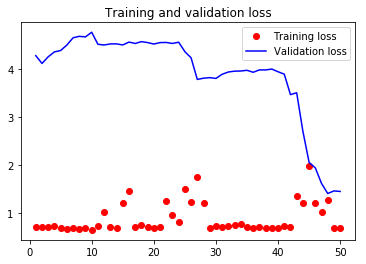

In [368]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

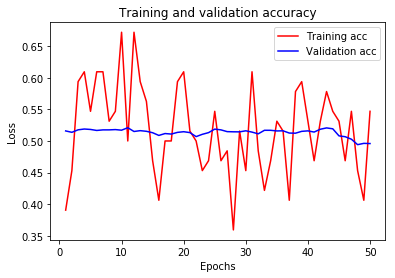

In [369]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [370]:
model.save("LSTM1.h5")

In [371]:
from keras.models import load_model
model = load_model("LSTM1.h5")
test_loss, test_acc = model.evaluate_generator(test_gen, steps=3)
print('test acc:', test_acc)
print("test_loss:", test_loss)

test acc: 0.5208333333333334
test_loss: 1.9676896731058757


## Training and evaluating a GRU-based model

In [257]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, normalized_df1.shape[-1])))

model.add(layers.Dense(2))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 32)                4800      
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 66        
Total params: 4,866
Trainable params: 4,866
Non-trainable params: 0
_________________________________________________________________


In [258]:
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=2,
                              epochs=50,
                              validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/50
2/2 [==============================] - 4s 2s/step - loss: 8.5030 - acc: 0.3750 - val_loss: 2.2249 - val_acc: 0.4930
Epoch 2/50
2/2 [==============================] - 2s 1s/step - loss: 5.2931 - acc: 0.5000 - val_loss: 2.1036 - val_acc: 0.4942
Epoch 3/50
2/2 [==============================] - 2s 1s/step - loss: 0.7472 - acc: 0.4375 - val_loss: 2.0666 - val_acc: 0.4856
Epoch 4/50
2/2 [==============================] - 2s 1s/step - loss: 0.6477 - acc: 0.6250 - val_loss: 2.1424 - val_acc: 0.4825
Epoch 5/50
2/2 [==============================] - 2s 1s/step - loss: 0.7507 - acc: 0.3750 - val_loss: 2.1736 - val_acc: 0.4775
Epoch 6/50
2/2 [==============================] - 2s 1s/step - loss: 3.5072 - acc: 0.5000 - val_loss: 2.0216 - val_acc: 0.4829
Epoch 7/50
2/2 [==============================] - 2s 1s/step - loss: 2.5265 - acc: 0.6250 - val_loss: 1.9324 - val_acc: 0.4865
Epoch 8/50
2/2 [==============================] - 2s 1s/step - loss: 0.7099 - acc: 0.5625 - val_loss: 1.9699 - 

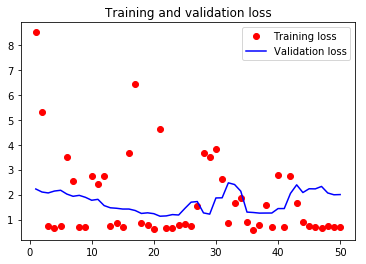

In [259]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

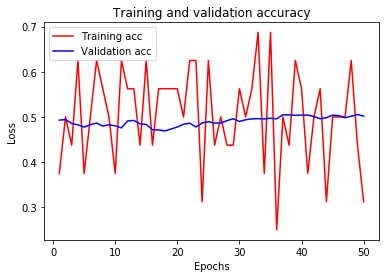

In [260]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [261]:
model.save("GRU.h5")

In [262]:
model = load_model("GRU.h5")
test_loss, test_acc = model.evaluate_generator(test_gen, steps=20)
print('test acc:', test_acc)
print("test_loss:", test_loss)

test acc: 0.5375
test_loss: 2.3329139590263366


# Training and evaluating a dropout-regularized GRU-based model

In [270]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.4,
                     input_shape=(None, normalized_df1.shape[-1])))
model.add(layers.Dense(2))
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=2,
                              epochs=50,
                              validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/50
2/2 [==============================] - 5s 3s/step - loss: 1.4603 - acc: 0.6250 - val_loss: 3.6752 - val_acc: 0.5020
Epoch 2/50
2/2 [==============================] - 2s 1s/step - loss: 0.8385 - acc: 0.3125 - val_loss: 3.6551 - val_acc: 0.4915
Epoch 3/50
2/2 [==============================] - 3s 1s/step - loss: 0.5352 - acc: 0.6250 - val_loss: 4.2234 - val_acc: 0.4956
Epoch 4/50
2/2 [==============================] - 2s 1s/step - loss: 4.5654 - acc: 0.5625 - val_loss: 3.2863 - val_acc: 0.4890
Epoch 5/50
2/2 [==============================] - 2s 1s/step - loss: 1.6522 - acc: 0.6250 - val_loss: 2.9508 - val_acc: 0.4960
Epoch 6/50
2/2 [==============================] - 3s 1s/step - loss: 0.7492 - acc: 0.7500 - val_loss: 2.3553 - val_acc: 0.4996
Epoch 7/50
2/2 [==============================] - 3s 1s/step - loss: 1.6829 - acc: 0.3750 - val_loss: 2.3293 - val_acc: 0.4987
Epoch 8/50
2/2 [==============================] - 3s 1s/step - loss: 0.6015 - acc: 0.7500 - val_loss: 2.3587 - 

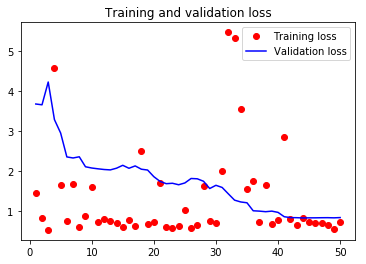

In [271]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

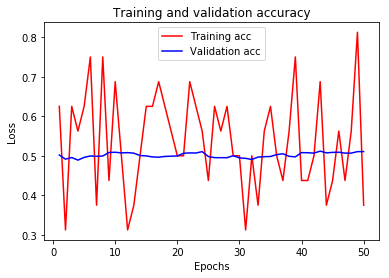

In [272]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [273]:
model.save("GRU_dropout.h5")

In [274]:
model = load_model("GRU_dropout.h5")
test_loss, test_acc = model.evaluate_generator(test_gen, steps=20)
print('test acc:', test_acc)
print("test_loss:", test_loss)

test acc: 0.4625
test_loss: 0.756367951631546


# Stacking Recurrent Layers

## Training and evaluating a dropout-regularized, stacked GRU model

In [283]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, normalized_df1.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(2))
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=2,
                              epochs=2,
                              validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/2
2/2 [==============================] - 7s 3s/step - loss: 1.5281 - acc: 0.4375 - val_loss: 7.5121 - val_acc: 0.4927
Epoch 2/2
2/2 [==============================] - 4s 2s/step - loss: 1.7799 - acc: 0.3750 - val_loss: 7.4336 - val_acc: 0.4907


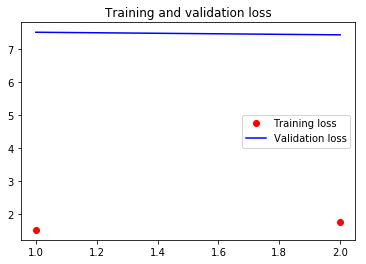

In [284]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

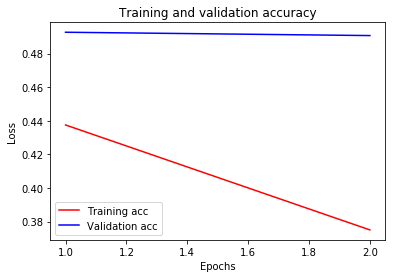

In [285]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [286]:
model.save("GRU_stacked.h5")

In [287]:
model = load_model("GRU_stacked.h5")
test_loss, test_acc = model.evaluate_generator(test_gen, steps=20)
print('test acc:', test_acc)
print("test_loss:", test_loss)

test acc: 0.525
test_loss: 7.137110847234726


### Normal LSTM model is performing better than others

Let's compare which set of Technical Indicators works well.

In [288]:
normalized_df2 = normalized_df2.values
normalized_df3 = normalized_df3.values
normalized_df4 = normalized_df4.values

In [305]:
lookback = 5
step = 5
delay = 5
batch_size = 32

In [306]:
train_gen = generator(normalized_df2,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=round(0.6*len(normalized_df2)),
                      shuffle=False,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(normalized_df2,
                    lookback=lookback,
                    delay=delay,
                    min_index=round(0.6*len(normalized_df2))+1,
                    max_index=round(0.8*len(normalized_df2)),
                    step=step,
                    batch_size=batch_size)
test_gen = generator(normalized_df2,
                     lookback=lookback,
                     delay=delay,
                     min_index=round(0.8*len(normalized_df2))+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (round(0.8*len(normalized_df2)) - round(0.6*len(normalized_df2))+1 - lookback) # how many steps to draw from val_gen in order to see the entire validation set
test_steps = (len(normalized_df2) - round(0.8*len(normalized_df2))+1 - lookback)

In [307]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, normalized_df2.shape[-1]))) 
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_20 (Flatten)         (None, 14)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 8)                 120       
_________________________________________________________________
dense_67 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_68 (Dense)             (None, 2)                 18        
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________


In [329]:

model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=2, 
                              epochs=5, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/5
2/2 [==============================] - 7s 3s/step - loss: 1.0344 - acc: 0.5000 - val_loss: 7.3865 - val_acc: 0.5302
Epoch 2/5
2/2 [==============================] - 3s 1s/step - loss: 0.7721 - acc: 0.5156 - val_loss: 7.3377 - val_acc: 0.5310
Epoch 3/5
2/2 [==============================] - 3s 1s/step - loss: 1.3503 - acc: 0.3906 - val_loss: 7.3524 - val_acc: 0.5306
Epoch 4/5
2/2 [==============================] - 3s 1s/step - loss: 1.0155 - acc: 0.5156 - val_loss: 7.3461 - val_acc: 0.5320
Epoch 5/5
2/2 [==============================] - 3s 2s/step - loss: 1.1824 - acc: 0.5312 - val_loss: 7.3355 - val_acc: 0.5317


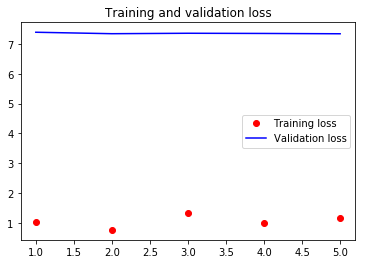

In [330]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

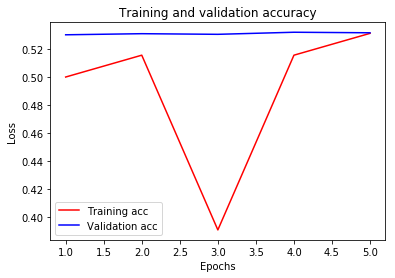

In [331]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [332]:
model.save("LSTM2.h5")

In [333]:

model = load_model("LSTM2.h5")
test_loss, test_acc = model.evaluate_generator(test_gen, steps=3)
print('test acc:', test_acc)
print("test_loss:", test_loss)

test acc: 0.625
test_loss: 8.46192741394043


In [334]:
train_gen = generator(normalized_df3,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=round(0.6*len(normalized_df3)),
                      shuffle=False,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(normalized_df3,
                    lookback=lookback,
                    delay=delay,
                    min_index=round(0.6*len(normalized_df3))+1,
                    max_index=round(0.8*len(normalized_df3)),
                    step=step,
                    batch_size=batch_size)
test_gen = generator(normalized_df3,
                     lookback=lookback,
                     delay=delay,
                     min_index=round(0.8*len(normalized_df3))+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (round(0.8*len(normalized_df3)) - round(0.6*len(normalized_df3))+1 - lookback) # how many steps to draw from val_gen in order to see the entire validation set
test_steps = (len(normalized_df3) - round(0.8*len(normalized_df3))+1 - lookback)

In [335]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, normalized_df3.shape[-1]))) 
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_21 (Flatten)         (None, 17)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 8)                 144       
_________________________________________________________________
dense_70 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_71 (Dense)             (None, 2)                 18        
Total params: 234
Trainable params: 234
Non-trainable params: 0
_________________________________________________________________


In [342]:
model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=5, 
                              epochs=29, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/29
5/5 [==============================] - 6s 1s/step - loss: 1.7101 - acc: 0.4438 - val_loss: 1.2682 - val_acc: 0.4964
Epoch 2/29
5/5 [==============================] - 3s 593ms/step - loss: 0.6519 - acc: 0.6625 - val_loss: 1.2491 - val_acc: 0.4962
Epoch 3/29
5/5 [==============================] - 3s 630ms/step - loss: 0.6826 - acc: 0.5875 - val_loss: 1.1831 - val_acc: 0.4986
Epoch 4/29
5/5 [==============================] - 3s 574ms/step - loss: 0.6875 - acc: 0.5875 - val_loss: 1.1800 - val_acc: 0.4959
Epoch 5/29
5/5 [==============================] - 3s 542ms/step - loss: 0.6854 - acc: 0.5812 - val_loss: 1.1968 - val_acc: 0.4947
Epoch 6/29
5/5 [==============================] - 3s 615ms/step - loss: 0.6642 - acc: 0.6125 - val_loss: 1.1967 - val_acc: 0.4949
Epoch 7/29
5/5 [==============================] - 3s 649ms/step - loss: 0.6803 - acc: 0.6125 - val_loss: 1.1897 - val_acc: 0.4966
Epoch 8/29
5/5 [==============================] - 3s 627ms/step - loss: 0.6667 - acc: 0.6063 

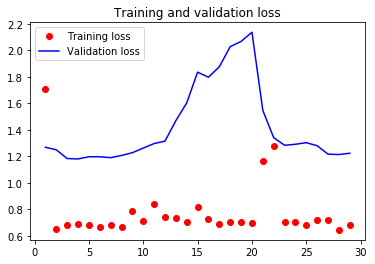

In [343]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

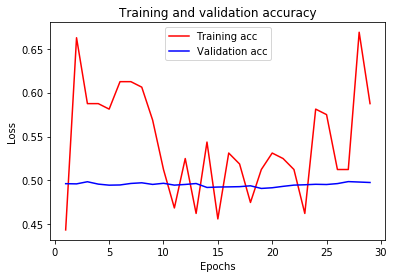

In [344]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [345]:
model.save("LSTM3.h5")

In [346]:
model = load_model("LSTM3.h5")
test_loss, test_acc = model.evaluate_generator(test_gen, steps=3)
print('test acc:', test_acc)
print("test_loss:", test_loss)

test acc: 0.5520833333333334
test_loss: 1.3780630429585774
